- WISDM dataset
  - sitting 4500 - (normal)
  - running 4500 - (abnormal)
- activity를 label로 설정

GAN Anomaly Detection

https://github.com/MyungKyuYi/Tutorial/blob/main/GAN_Frauld_Anomaly_Detection.ipynb

In [143]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [144]:
df = pd.read_csv("/content/drive/MyDrive/WISDM.csv")
df = df.drop('user-id', axis=1)
df = df.drop('timestamp', axis=1)
df = df.drop(df.columns[0], axis=1)

#Sitting = df[df['activity']=='Sitting'].head(4499).copy()
#Jogging = df[df['activity']=='Jogging'].head(4500).copy()
#df = pd.concat([Jogging, Sitting])

Sitting = df[df['activity']=='Sitting']
Jogging = df[df['activity']=='Jogging']
df = pd.concat([Jogging, Sitting])

df.head()

,activity,X,Y,Z
0,Jogging,-0.6946377,12.6805440,0.5039529
1,Jogging,5.0122880,11.2640280,0.9534243
2,Jogging,4.9033250,10.8826580,-0.0817221
3,Jogging,-0.6129156,18.4964310,3.0237172
4,Jogging,-1.1849703,12.1084890,7.2051640


In [145]:
df['activity'].value_counts()

from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

df['activity']=le.fit_transform(df['activity'])

In [146]:
df['activity'].value_counts()

0    342176
1     59939
Name: activity, dtype: int64

- 1: Sitting(normal)
- 0: Running(abnormal)

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((257353, 4), (64339, 4), (80423, 4))

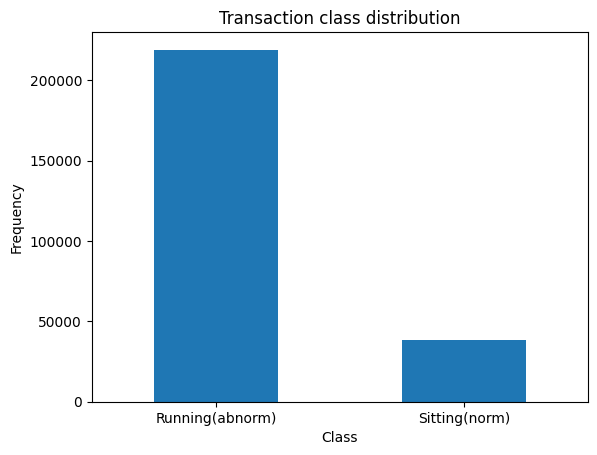

In [148]:
LABELS = ["Running(abnorm)", "Sitting(norm)"]

count_classes = pd.value_counts(X_train['activity'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [149]:
# Normal = Sitting, False = Jogging

X_train = X_train[X_train.activity == 1]
X_train = X_train.drop(['activity'], axis=1)

X_val = X_val[X_val.activity == 1]
X_val = X_val.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [150]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [151]:
X_train.shape

(38372, 3)

In [152]:
NUM_COL=3

In [153]:
#Setting the Hyperparameters

#learning_rate = 0.00001
learning_rate = 0.0001
batch_size = 512
epochs = 5
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

In [154]:
# Defining the Generator network

def get_generator(optimizer):

    generator = Sequential()
    generator.add(Dense(64, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))

    generator.add(Dense(128))
    generator.add(Activation('tanh'))

    generator.add(Dense(256))
    generator.add(Activation('tanh'))

    generator.add(Dense(256))
    generator.add(Activation('tanh'))

    generator.add(Dense(512))
    generator.add(Activation('tanh'))

    generator.add(Dense(NUM_COL, activation='tanh'))

    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return generator

In [155]:
##### Defining the Discriminator network

def get_discriminator(optimizer):

    discriminator = Sequential()

    discriminator.add(Dense(512, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(256))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(256))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(64))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [156]:
def get_gan_network(discriminator, generator, optimizer,input_dim=NUM_COL):

    discriminator.trainable = False
    gan_input = Input(shape=(input_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))


    return gan

In [167]:
#Training the GAN
from tqdm import tqdm
from keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import Activation




#Calculating the number of batches based on the batch size
batch_count = X_train.shape[0] // batch_size
pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=NUM_COL)


for epoch in range(epochs):
    for index in range(batch_count):
        pbar.update(1)
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,NUM_COL])

        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)

        #Obtain a batch of normal network packets
        image_batch = X_train[index * batch_size: (index + 1) * batch_size]

        X = np.vstack((generated_images,image_batch))
        y_dis = np.ones(2*batch_size)
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)

        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)

    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))




100%|██████████| 370/370 [00:56<00:00,  6.55it/s]

 22%|██▏       | 82/370 [00:09<00:07, 39.94it/s]

Epoch 0 Batch 73/74 [D loss: 0.433379] [G loss:0.954599]



 42%|████▏     | 157/370 [00:11<00:04, 42.66it/s]

Epoch 1 Batch 73/74 [D loss: 0.624028] [G loss:1.131369]



 63%|██████▎   | 232/370 [00:12<00:03, 43.08it/s]

Epoch 2 Batch 73/74 [D loss: 0.422934] [G loss:0.900232]



 82%|████████▏ | 302/370 [00:14<00:01, 44.80it/s]

Epoch 3 Batch 73/74 [D loss: 0.511427] [G loss:1.079767]



 99%|█████████▉| 368/370 [00:16<00:00, 32.15it/s]

Epoch 4 Batch 73/74 [D loss: 0.430950] [G loss:1.680287]


#평가

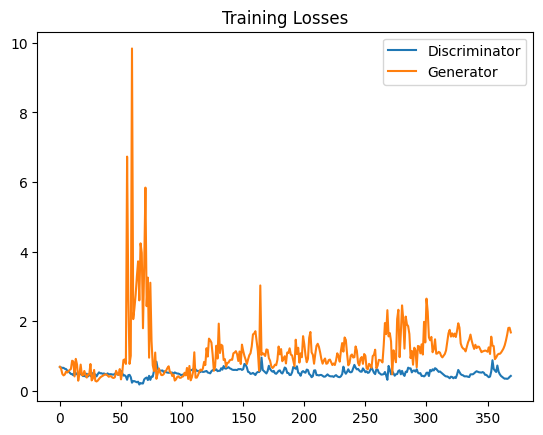

In [168]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [169]:
# Predictions on the test set

nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)
        results = np.append(results, tmp_rslt)


100%|██████████| 370/370 [00:32<00:00, 32.15it/s]

In [170]:
results

array([1.23929612e-01, 9.19641793e-01, 9.88956153e-01, ...,
       9.77359474e-01, 1.19501753e-09, 9.70015883e-01])

In [171]:
y2 = y_test.to_numpy()

In [172]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Normal data :', results_df.loc[results_df['y_test'] == 1, 'results'].mean() )
print ('Mean score for Fall data :', results_df.loc[results_df['y_test'] == 0, 'results'].mean())


Mean score for Normal data : 0.7389182223038983
Mean score for Fall data : 0.4699638204414355


In [173]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [174]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.8396975989455753
Precision : 0.0
Recall : 0.0
F1 : 0.0


Confusion Matrix :


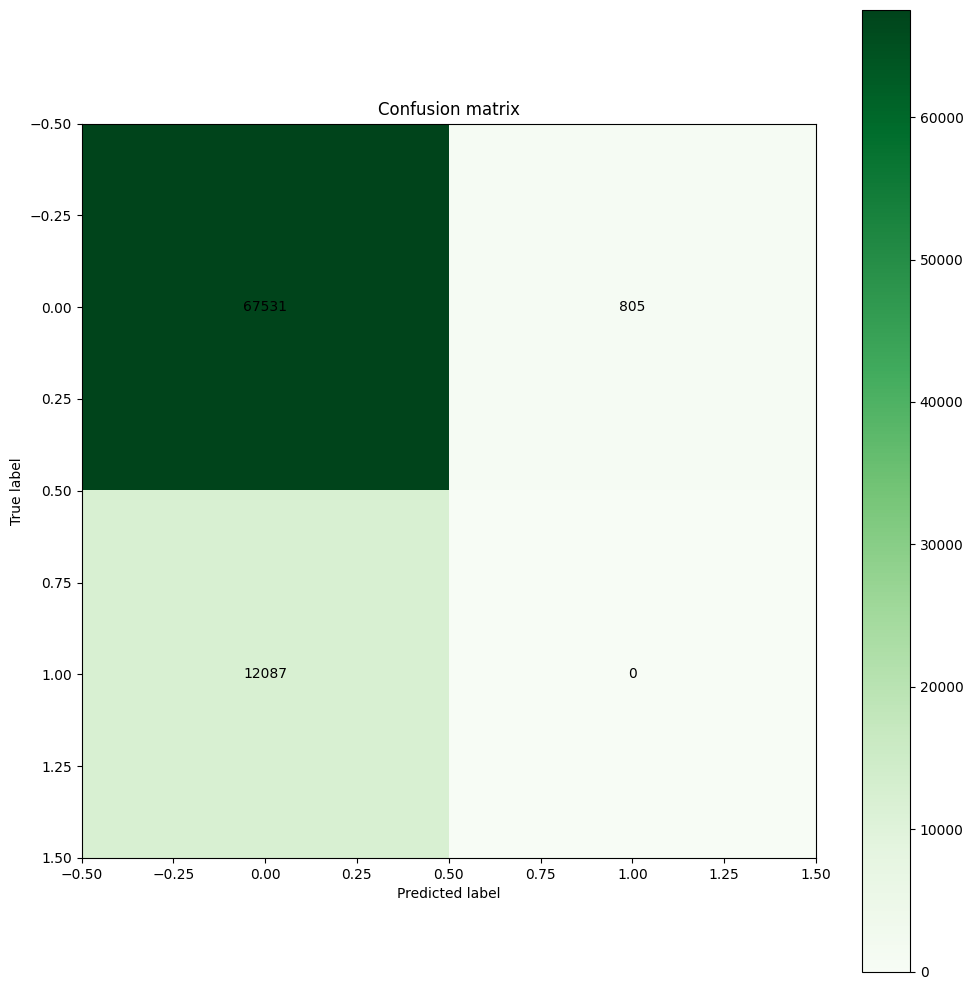

In [175]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

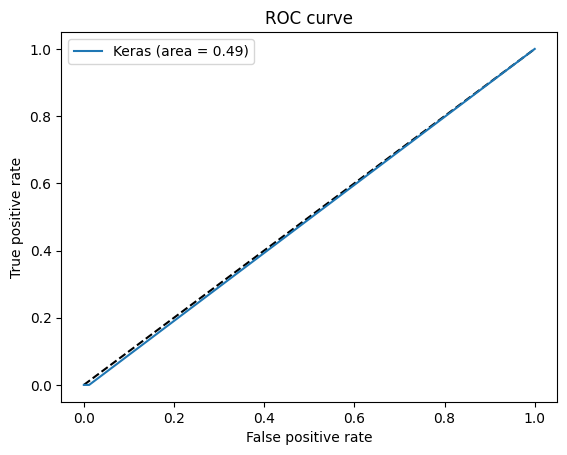

In [176]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()